# **Necessary Libs**

In [1]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
from torchtext.data import Field, TabularDataset, BucketIterator
from sklearn.model_selection import train_test_split
import string
import numpy as np
from torch import nn
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
import torchvision.transforms as tfs
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import accuracy_score
from sklearn import  metrics

# **Read Data**

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Utilities**

In [3]:
def myTokenize(text):
    return nltk.word_tokenize(text)

def buildVocab(myDir):
  capt = Field(sequential=True, init_token='<SOS>', eos_token='<EOS>', pad_token='<PAD>', unk_token='<UNK>',
                use_vocab=True, tokenize=myTokenize, lower=True)
  fields = {"sentence": ("q", capt)}
  train_data = TabularDataset(path=myDir, format="csv", fields=fields)
  capt.build_vocab(train_data, max_size=10000, min_freq=1, vectors="glove.42B.300d")
  return capt.vocab

def numericalize(text, vocab):
    tokenized_text = myTokenize(text)
    return [vocab.stoi[token] if token in vocab.stoi else vocab.stoi["<UNK>"] for token in tokenized_text]

def captionToInd(caption, vocab):
  return  [vocab.stoi["<SOS>"]] +  numericalize(caption, vocab) + [vocab.stoi["<EOS>"]]

# **Data Loader**

In [4]:
class RelationDataset(Dataset):
  def __init__(self, dataFrame, vocab):
    self.relationData = dataFrame
    self.vocab = vocab
  def __getitem__(self, idx):
    caption = self.relationData["sentence"].iloc[idx]
    captionInd = captionToInd(caption = caption, vocab = self.vocab)
    captionLabel = self.relationData["relation"].iloc[idx]
    entities = self.relationData[['e11', 'e12', 'e21', 'e22']].iloc[idx].values
    return torch.tensor(captionInd), torch.tensor(captionLabel), torch.tensor(entities)
  def __len__(self):
    return len(self.relationData)


# **Vocabulary, Train/Test Loader**

In [5]:
myDir = '../input/hw3-part3/train_file.csv'
vocab  = buildVocab(myDir = myDir)

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:52: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

**Train Dataset**

In [6]:
myDataFrame = pd.read_csv(myDir)
myDataFrame = myDataFrame.iloc[:7110]
myDataFrame["sentence"] = myDataFrame.sentence.str.lower()
trainDataFrame, valDataFrame = train_test_split(myDataFrame, test_size=0.05)
trainDataset = RelationDataset(dataFrame = trainDataFrame, vocab = vocab)
valDataset = RelationDataset(dataFrame = valDataFrame, vocab = vocab);

**Test Dataset**

In [7]:
myDataFrameTest = pd.read_csv('../input/hw3-part3/test_file.csv')
myDataFrame["sentence"] = myDataFrame.sentence.str.lower()
testDataset = RelationDataset(dataFrame = myDataFrameTest, vocab = vocab);

In [8]:
#https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/image_captioning/get_loader.py
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    def __call__(self, batch):
        label = torch.tensor([item[1] for item in batch])
        entities = [item[2].unsqueeze(0) for item in batch]
        entities = torch.cat(entities, dim=0)
        targets = [item[0] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return targets, label, entities

In [9]:

pad_idx = trainDataset.vocab.stoi['<PAD>']

In [10]:
trainRelationData = DataLoader(trainDataset, batch_size=8, shuffle=True, num_workers=0,  pin_memory=True,
  collate_fn=MyCollate(pad_idx=pad_idx))

valRelationData = DataLoader(valDataset, batch_size=len(valDataset), shuffle=True, num_workers=0,  pin_memory=True,
  collate_fn=MyCollate(pad_idx=pad_idx))
testRelationData = DataLoader(testDataset, batch_size=2000, shuffle=True, num_workers=0,  pin_memory=True,
  collate_fn=MyCollate(pad_idx=pad_idx))

# **Models**

In [11]:
class RelationNet(nn.Module):
  def __init__(self, embeddingDim, embeddingVectors, hiddenDim, numLayers, vocabLen, classNumbers = 10):
    super(RelationNet, self).__init__()
    self.embedding = nn.Embedding(vocabLen, embeddingDim, max_norm=True)  #Parameters are true?
    self.lstm = nn.LSTM(embeddingDim, hiddenDim, num_layers  = numLayers, bidirectional = True, dropout = 0.5)
    self.embedding.weight.data.copy_(embeddingVectors)
    self.embedding.weight.requires_grad = False
    self.linear = nn.Linear(in_features = 2*hiddenDim, out_features = classNumbers)
    self.maxPool = nn.MaxPool1d(hiddenDim+1, stride=1)
  def forward(self,caption, entities):
    captEmbd =  self.embedding(caption)
    h, (hidden, cell) = self.lstm(captEmbd)
    outputMax = self.maxPool(h)
    outEnt1, outEnt2 = attention(outputMax, entities)
    cat = torch.cat((outEnt1, outEnt2), dim=1)
    linearOutput = self.linear(cat)
    outputs = F.softmax(linearOutput, dim=1)
    return outputs
def attention(features, entities):
    outEnt1 = []; outEnt2 = []
    for i in range(np.shape(features)[1]):
        out1 = torch.mean(features[entities[i,0]:entities[i,1],i], dim = 0)
        out2 = torch.mean(features[entities[i,2]:entities[i,3],i], dim = 0)
        outEnt1.append(out1.unsqueeze(0))
        outEnt2.append(out2.unsqueeze(0))
    return torch.cat(outEnt1, dim=0), torch.cat(outEnt2, dim=0)

# **Train Model**

In [12]:
def myPlot(epoch, trainLoss, yLebel, title, test = None):
  plt.xlabel('Epoch')
  plt.ylabel(yLebel)
  plt.title(title)
  plt.plot(epoch, trainLoss, label='Train')
  if test:
     plt.plot(epoch, test, label='Val')
  plt.legend(loc='upper left')
  plt.show()

In [13]:
def calcTestLoss(testloader, net, criterion):
  totalLoss = 0; i = 0
  net.eval()
  with torch.no_grad():
    for imgSample,  caption in testloader:
      if torch.cuda.is_available:
        imgSample = imgSample.cuda()
        caption =  caption.cuda()
      i +=1
      outputs = net(imgSample, caption[0:caption.shape[0]-1])
      loss = criterion(outputs.reshape(-1, outputs.shape[2]), caption.reshape(-1))
      totalLoss += loss.item()
  avgLoss = totalLoss/i
  return avgLoss

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
def accuracy(true, pred):
    acc = (true == pred.argmax(-1)).float().detach().cpu().numpy()
    return float(acc.sum() / len(acc))    

In [16]:
embeddingVectors = vocab.vectors
embeddingDim = vocab.vectors.shape[1]
hiddenDim = 150
numLayers  = 2
vocabLen = len(trainDataset.vocab)
learningRate = 3e-4
numEpochs = 100
numClasses = 10

In [17]:
net = RelationNet(embeddingDim, embeddingVectors, hiddenDim, numLayers, vocabLen, numClasses)
if torch.cuda.is_available():
    net = net.cuda()
criterion = nn.CrossEntropyLoss(ignore_index=trainDataset.vocab.stoi["<PAD>"])
#optimizer = optim.Adam(net.parameters(), lr=learningRate)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)

In [18]:
lossTrainHist = []
epochHist = []
accTrainHist = []
accvalHist = []

****************** Epoch: 1  ******************


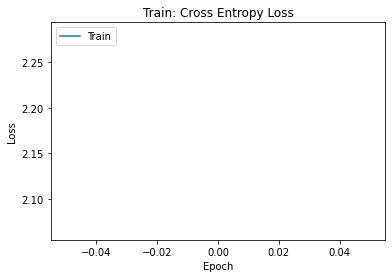

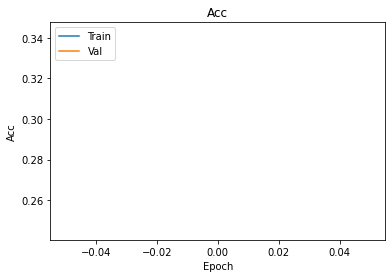

****************** Epoch: 2  ******************


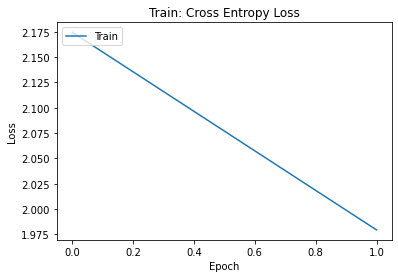

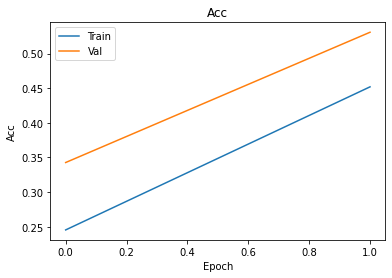

****************** Epoch: 3  ******************


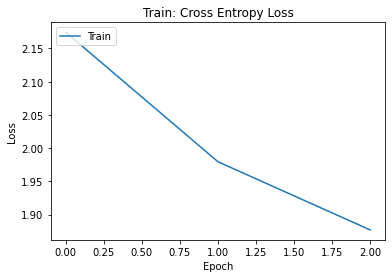

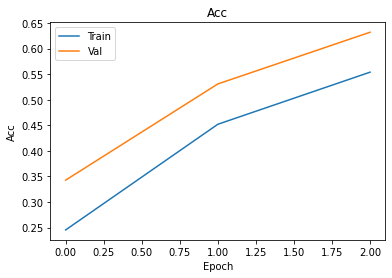

****************** Epoch: 4  ******************


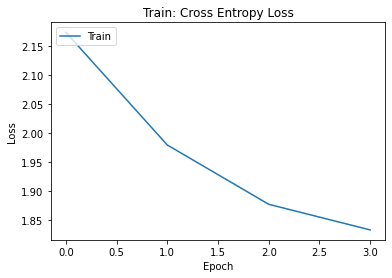

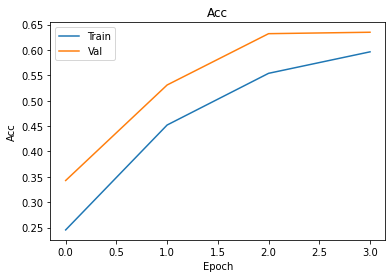

****************** Epoch: 5  ******************


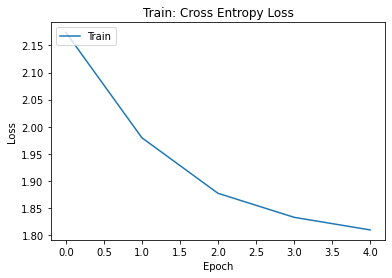

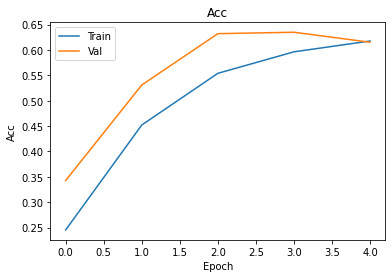

****************** Epoch: 6  ******************


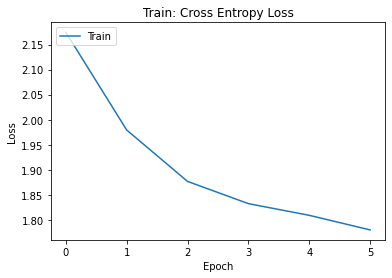

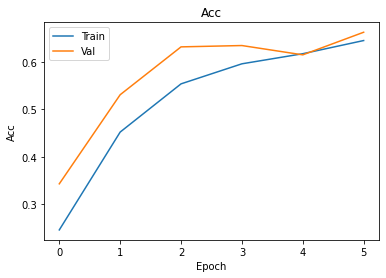

****************** Epoch: 7  ******************


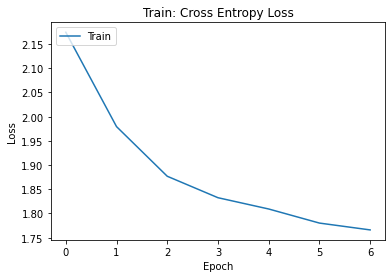

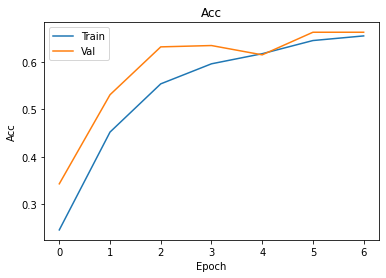

****************** Epoch: 8  ******************


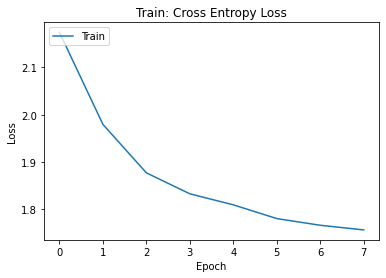

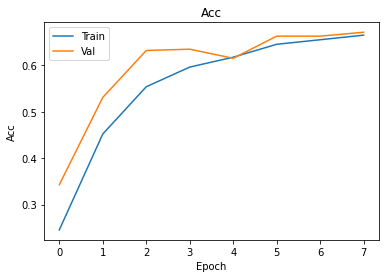

****************** Epoch: 9  ******************


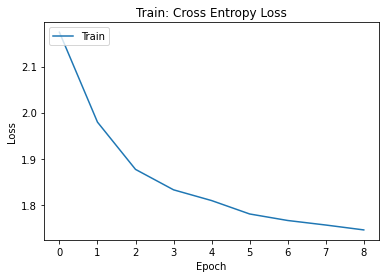

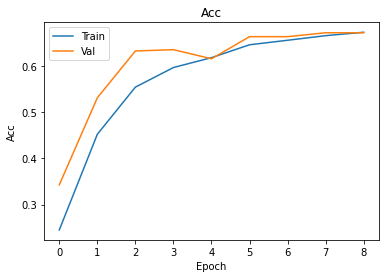

****************** Epoch: 10  ******************


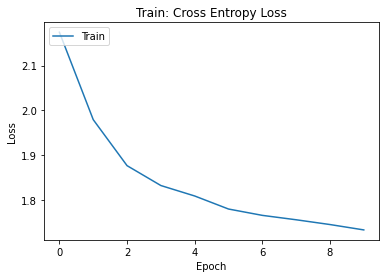

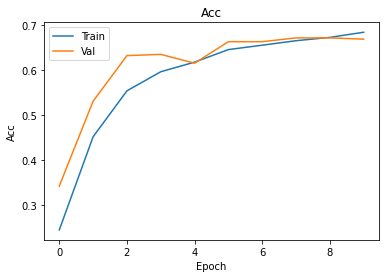

****************** Epoch: 11  ******************


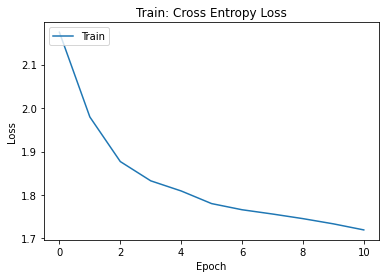

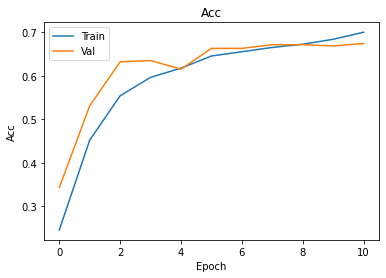

****************** Epoch: 12  ******************


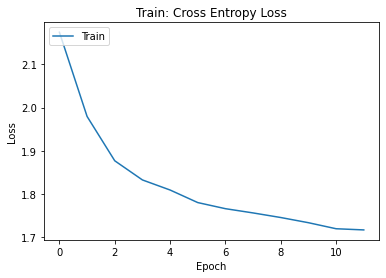

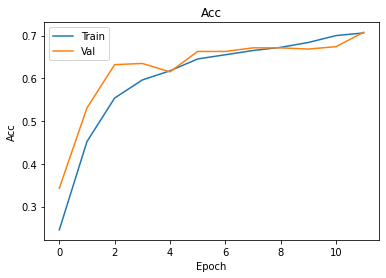

****************** Epoch: 13  ******************


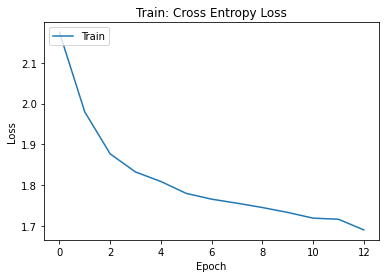

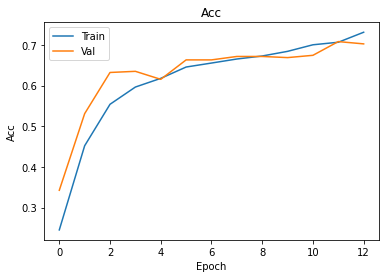

****************** Epoch: 14  ******************


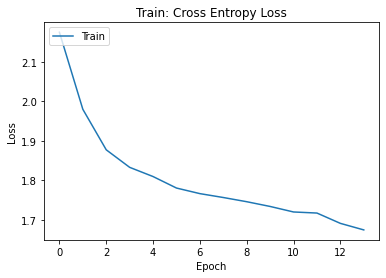

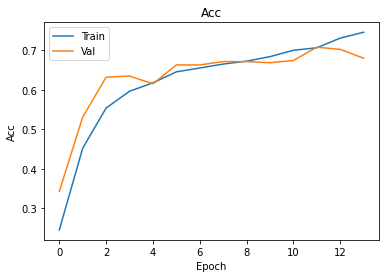

****************** Epoch: 15  ******************


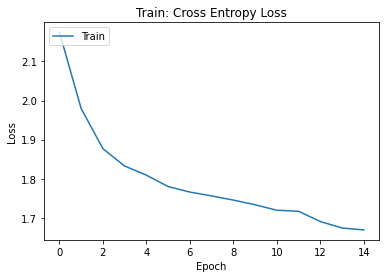

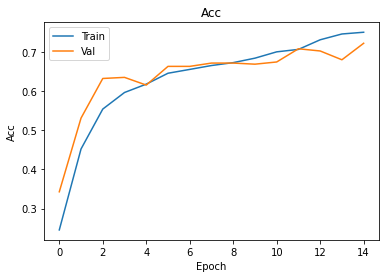

****************** Epoch: 16  ******************


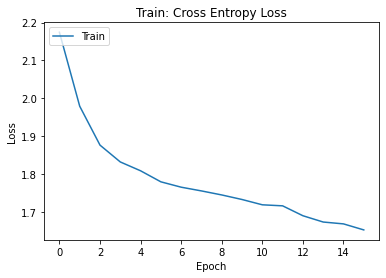

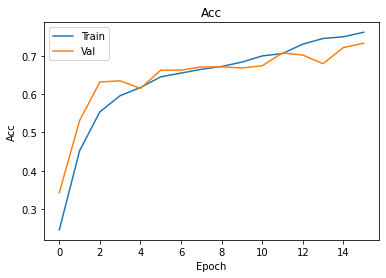

****************** Epoch: 17  ******************


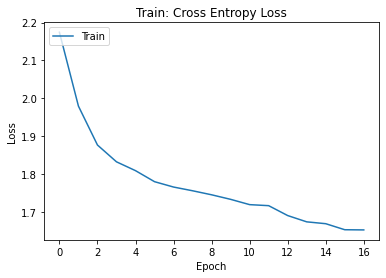

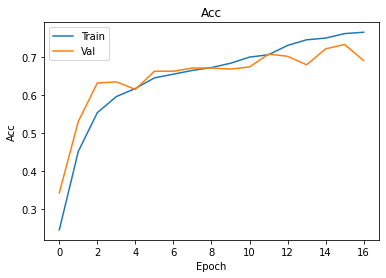

****************** Epoch: 18  ******************


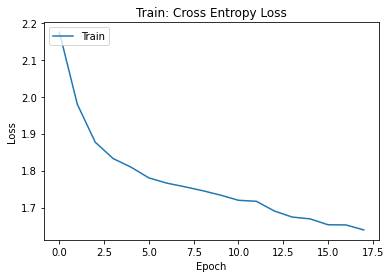

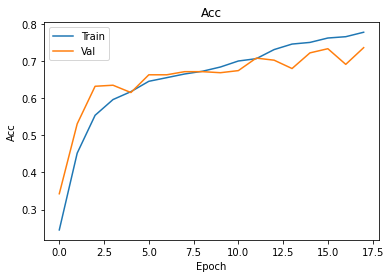

****************** Epoch: 19  ******************


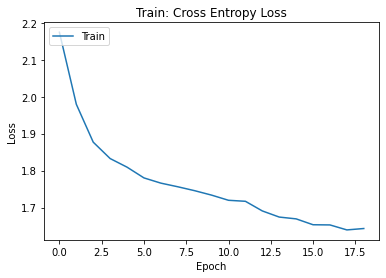

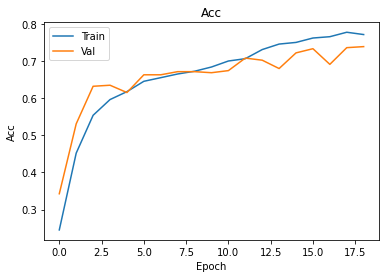

****************** Epoch: 20  ******************


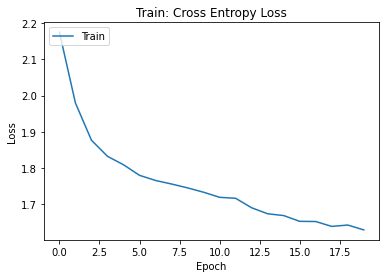

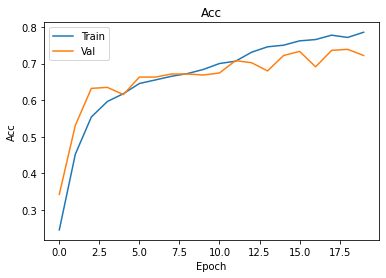

****************** Epoch: 21  ******************


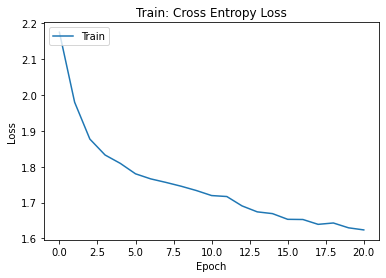

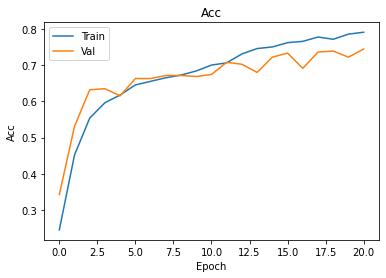

****************** Epoch: 22  ******************


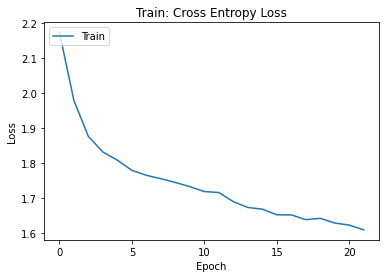

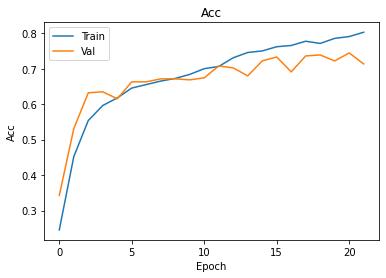

****************** Epoch: 23  ******************


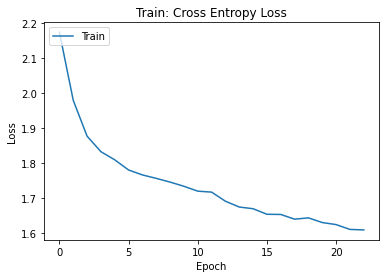

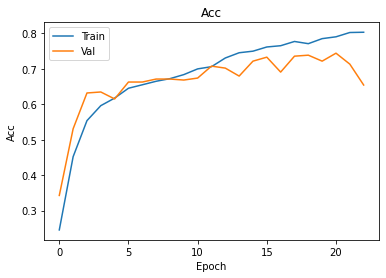

****************** Epoch: 24  ******************


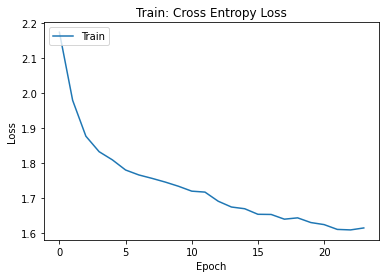

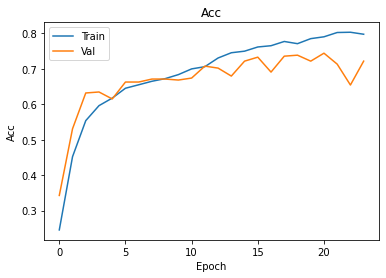

****************** Epoch: 25  ******************


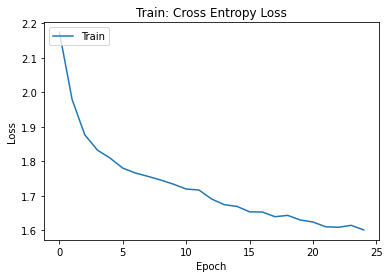

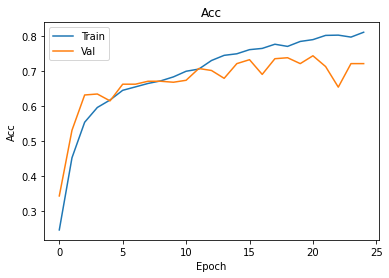

****************** Epoch: 26  ******************


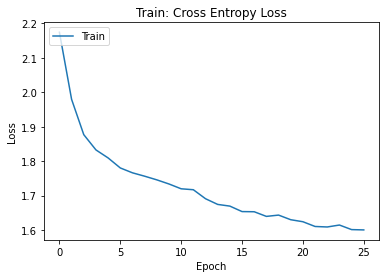

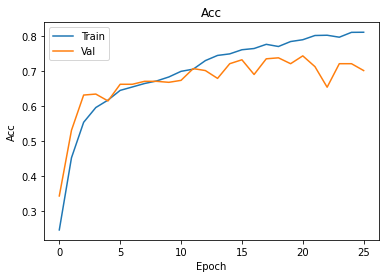

****************** Epoch: 27  ******************


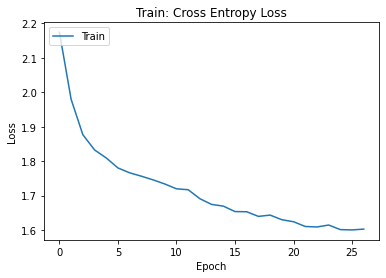

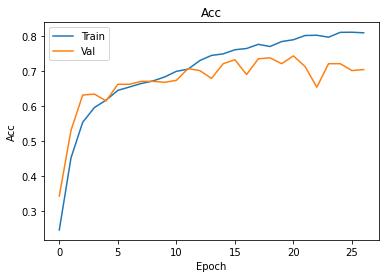

****************** Epoch: 28  ******************


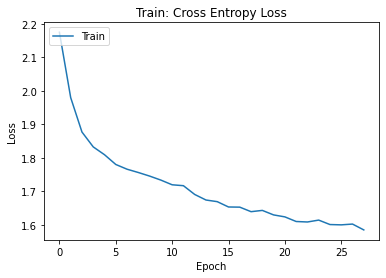

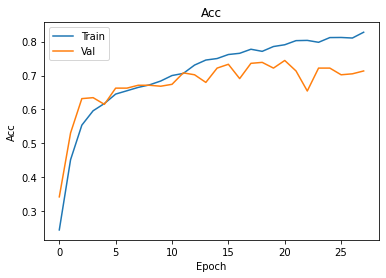

****************** Epoch: 29  ******************


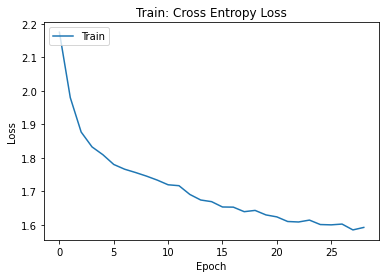

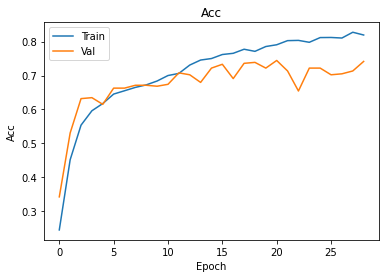

****************** Epoch: 30  ******************


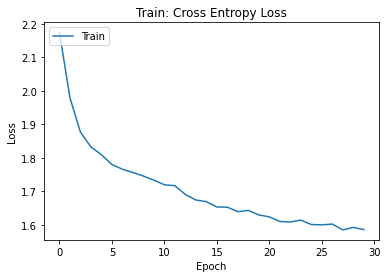

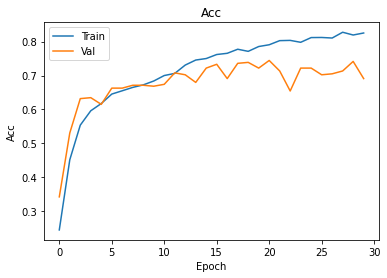

****************** Epoch: 31  ******************


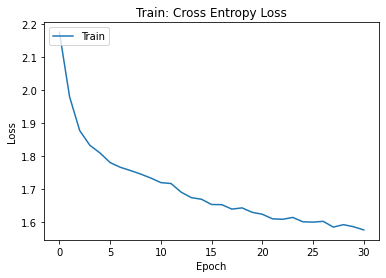

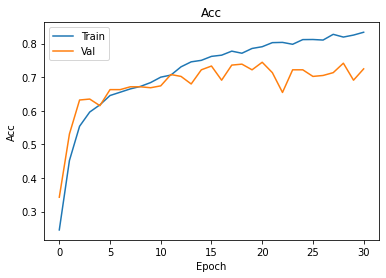

****************** Epoch: 32  ******************


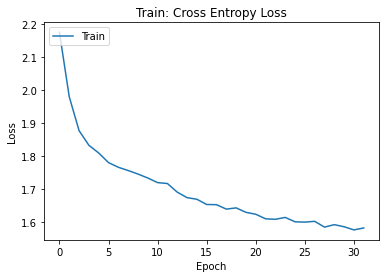

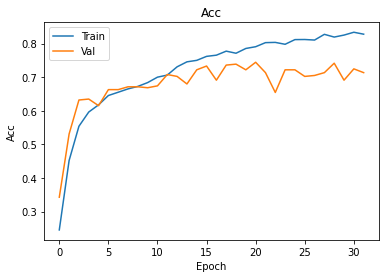

****************** Epoch: 33  ******************


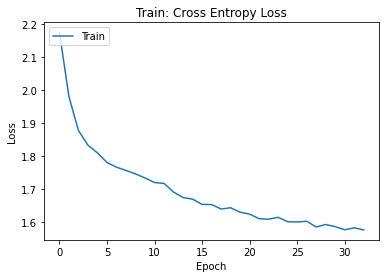

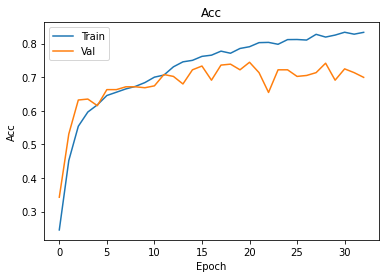

****************** Epoch: 34  ******************


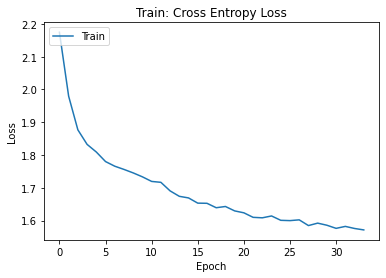

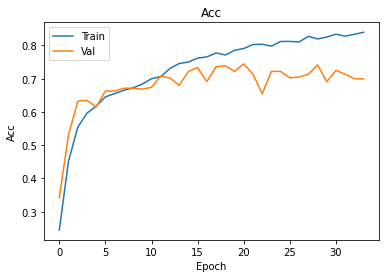

****************** Epoch: 35  ******************


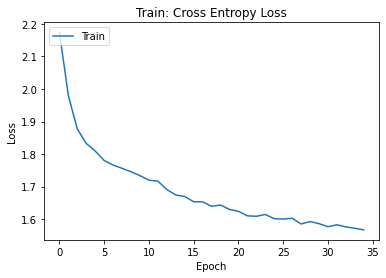

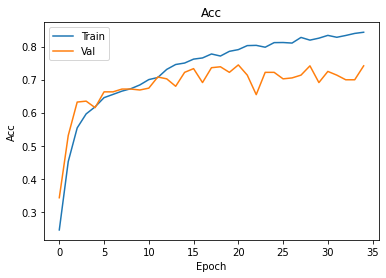

****************** Epoch: 36  ******************


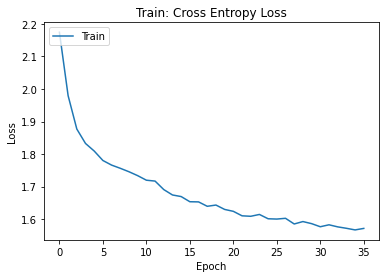

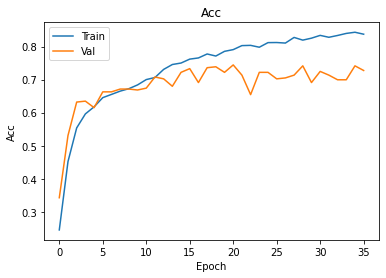

****************** Epoch: 37  ******************


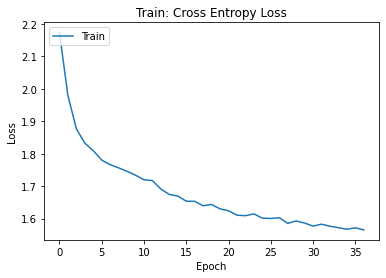

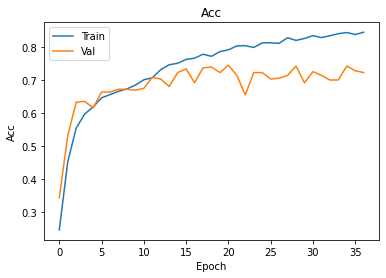

****************** Epoch: 38  ******************


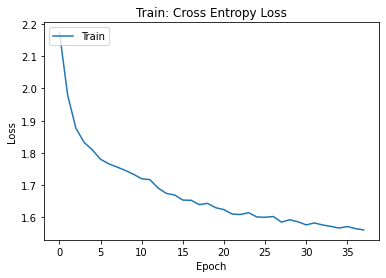

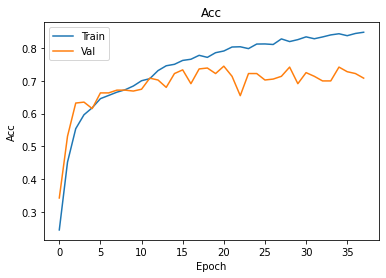

****************** Epoch: 39  ******************


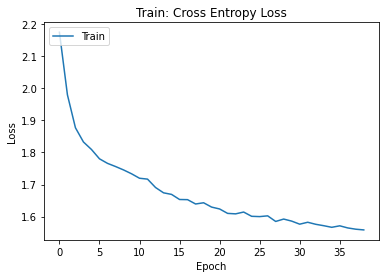

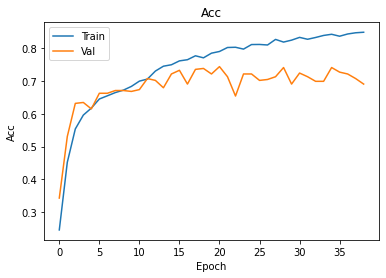

****************** Epoch: 40  ******************


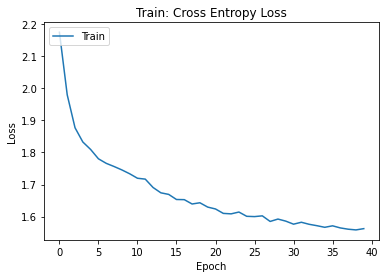

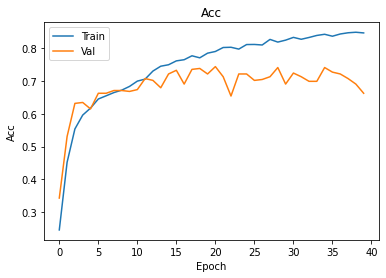

****************** Epoch: 41  ******************


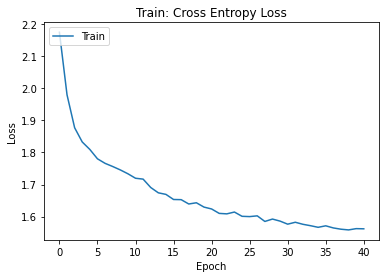

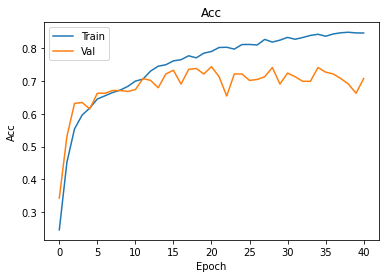

****************** Epoch: 42  ******************


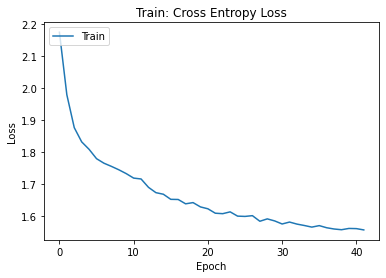

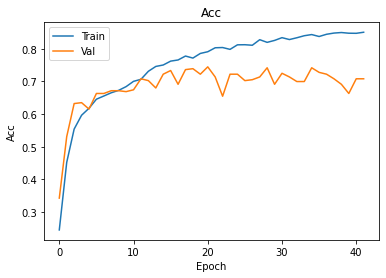

****************** Epoch: 43  ******************


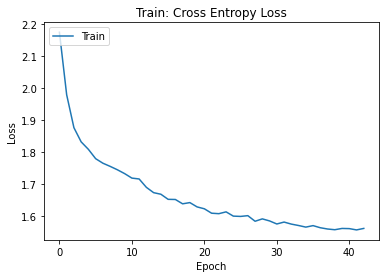

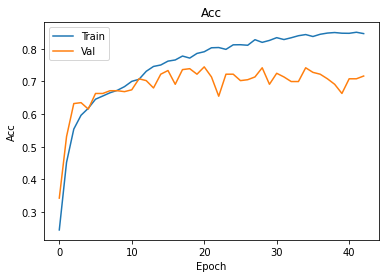

****************** Epoch: 44  ******************


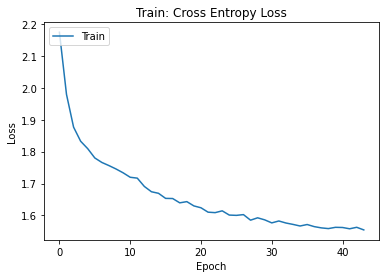

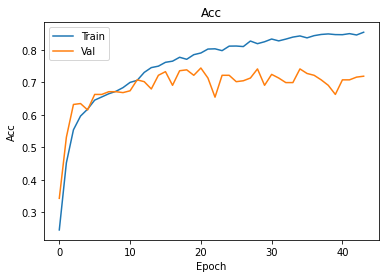

****************** Epoch: 45  ******************


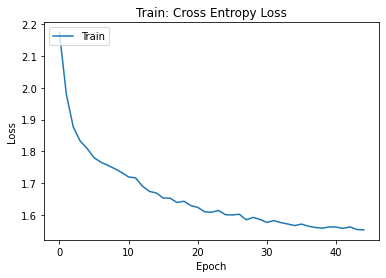

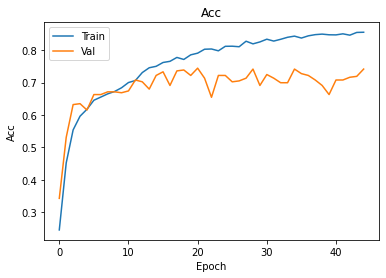

****************** Epoch: 46  ******************


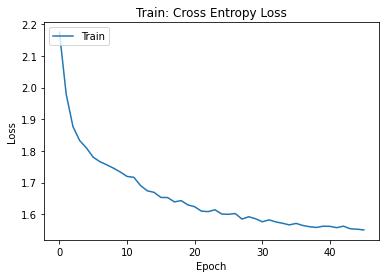

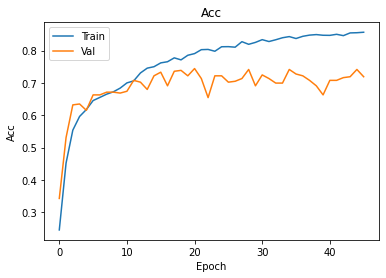

****************** Epoch: 47  ******************


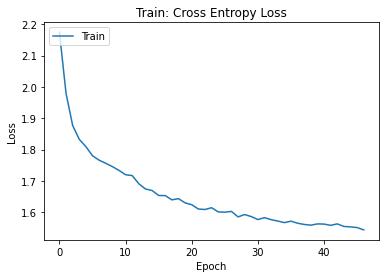

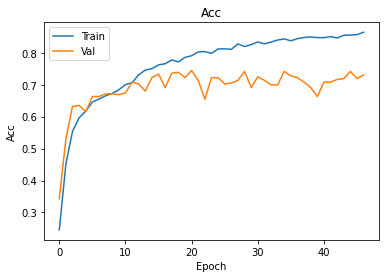

****************** Epoch: 48  ******************


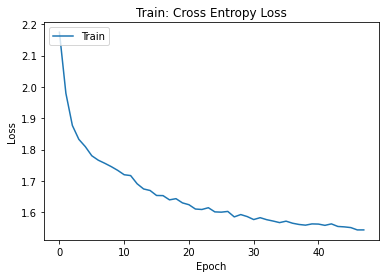

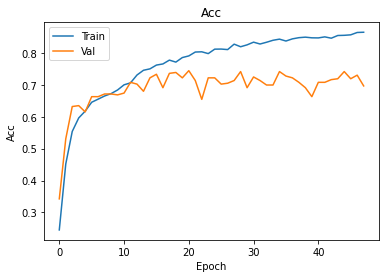

****************** Epoch: 49  ******************


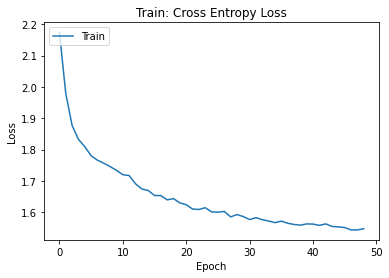

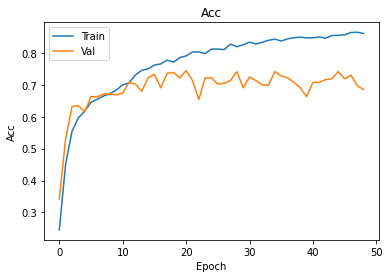

****************** Epoch: 50  ******************


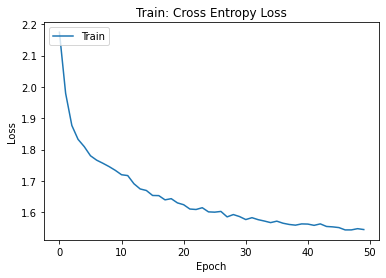

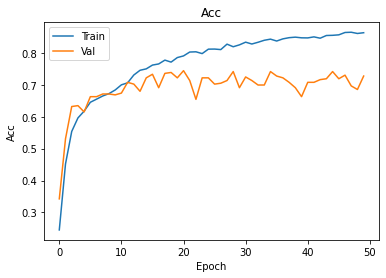

****************** Epoch: 51  ******************


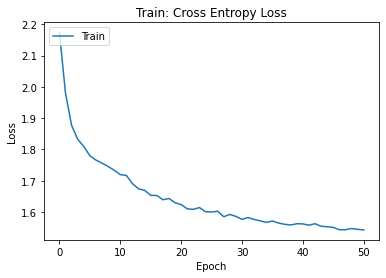

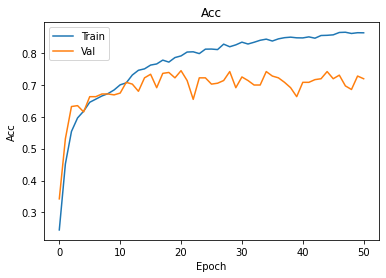

****************** Epoch: 52  ******************


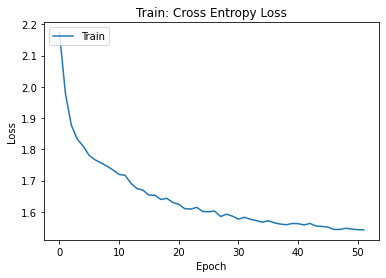

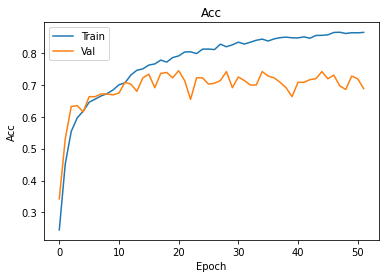

****************** Epoch: 53  ******************


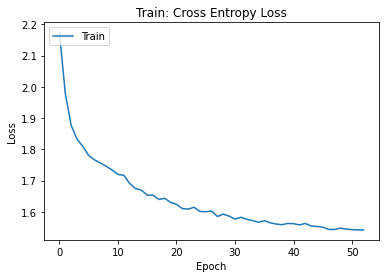

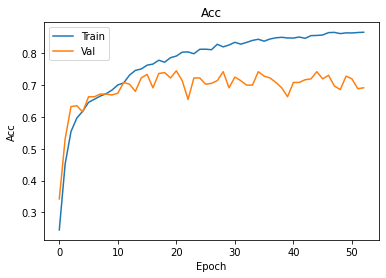

****************** Epoch: 54  ******************


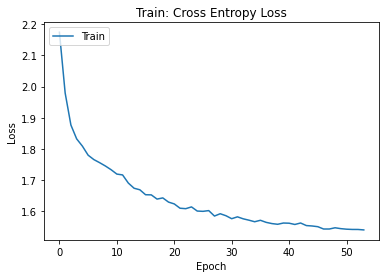

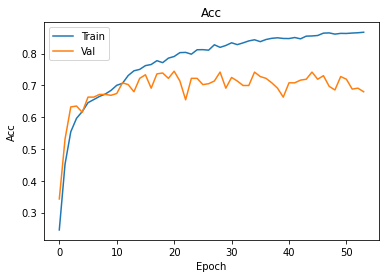

****************** Epoch: 55  ******************


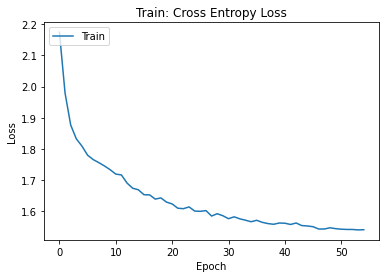

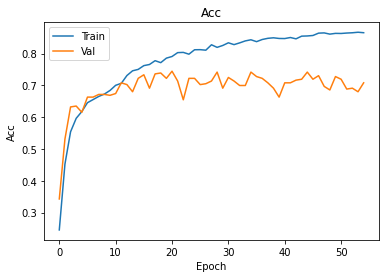

****************** Epoch: 56  ******************


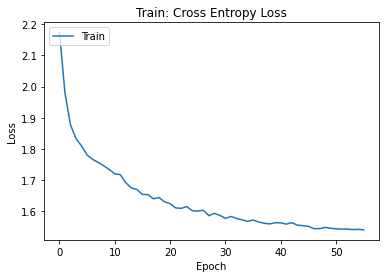

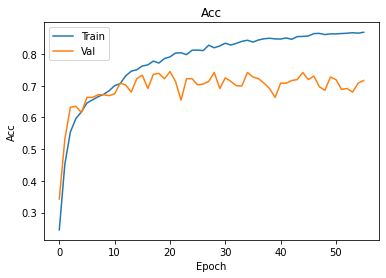

****************** Epoch: 57  ******************


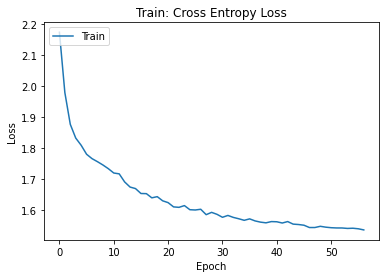

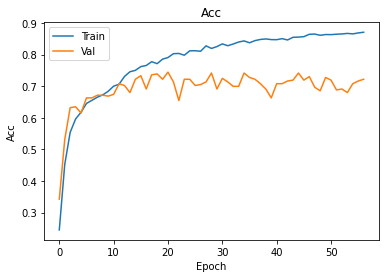

****************** Epoch: 58  ******************


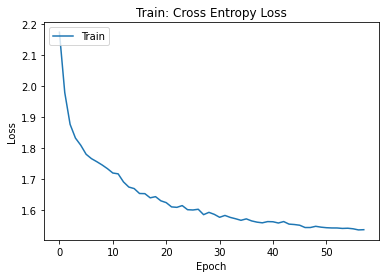

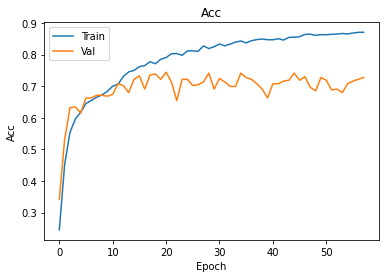

****************** Epoch: 59  ******************


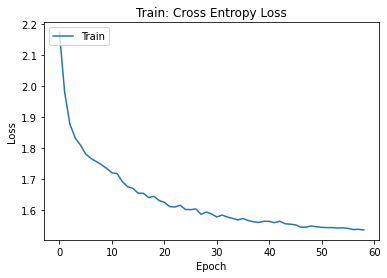

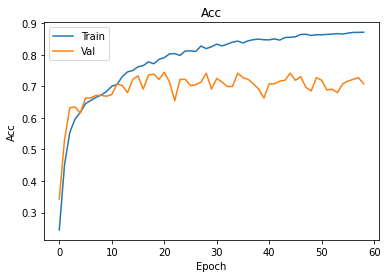

****************** Epoch: 60  ******************


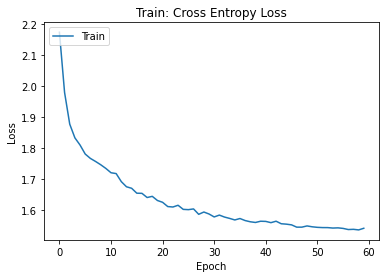

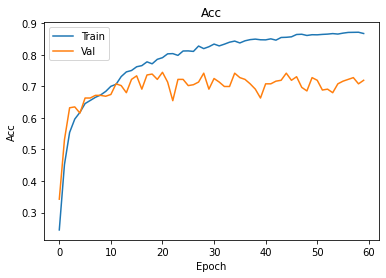

****************** Epoch: 61  ******************


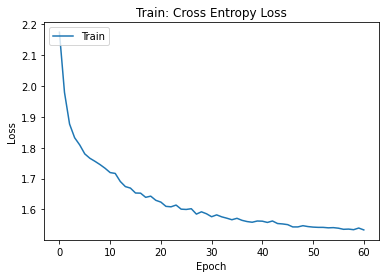

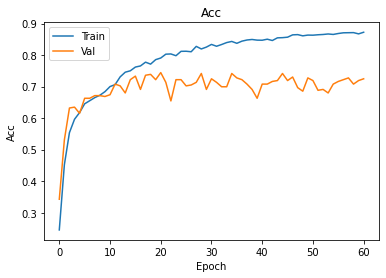

****************** Epoch: 62  ******************


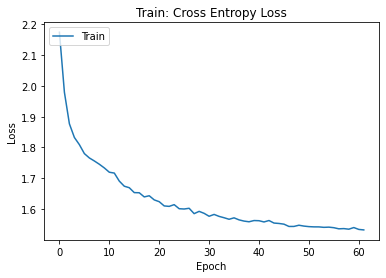

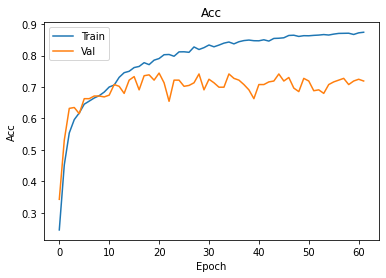

****************** Epoch: 63  ******************


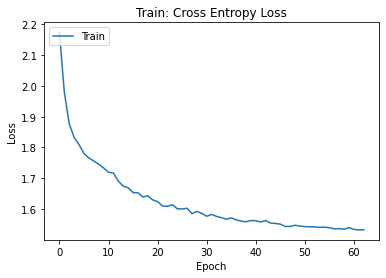

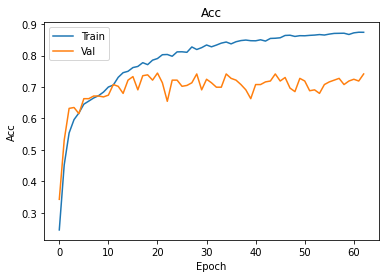

****************** Epoch: 64  ******************


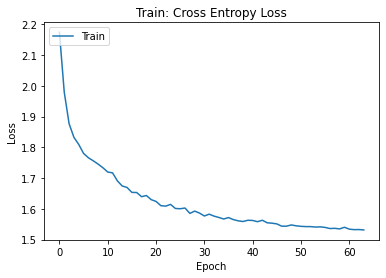

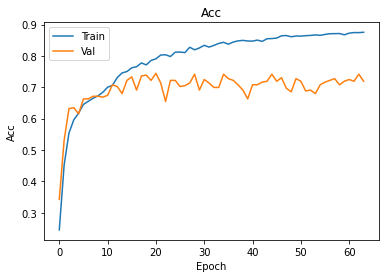

****************** Epoch: 65  ******************


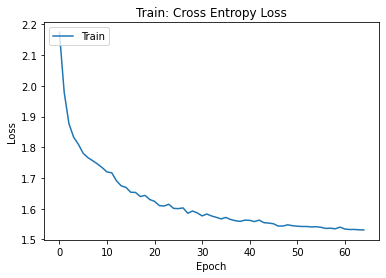

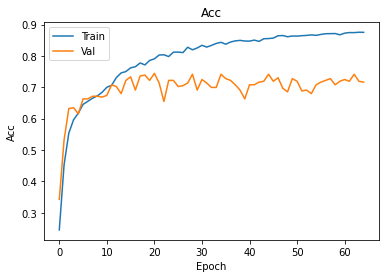

****************** Epoch: 66  ******************


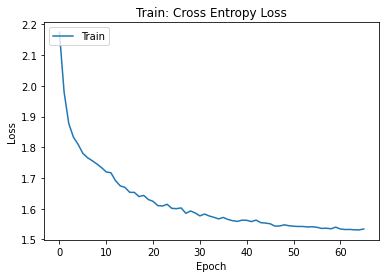

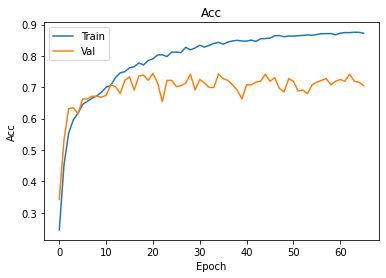

****************** Epoch: 67  ******************


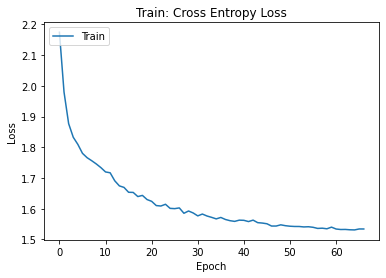

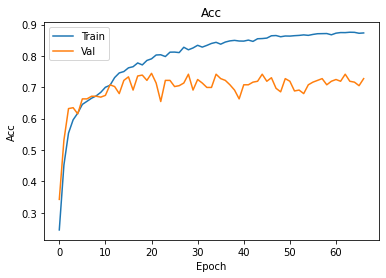

****************** Epoch: 68  ******************


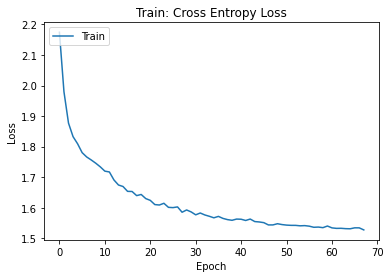

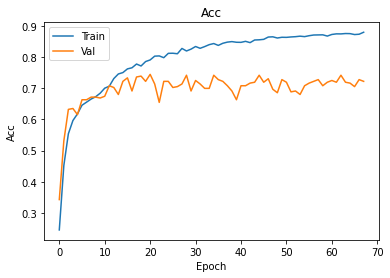

****************** Epoch: 69  ******************


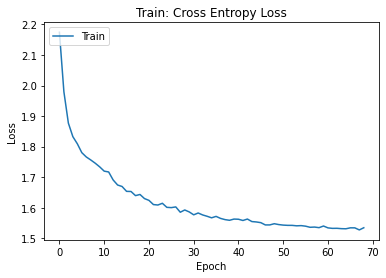

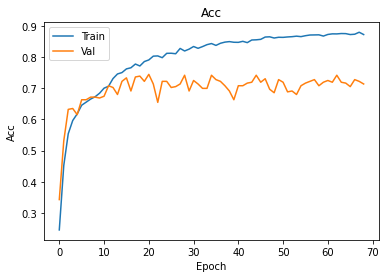

****************** Epoch: 70  ******************


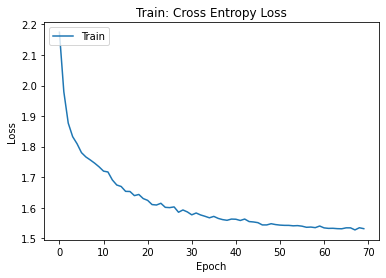

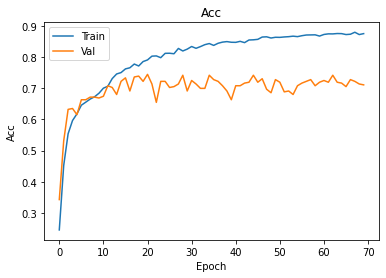

****************** Epoch: 71  ******************


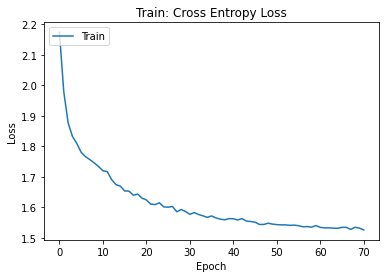

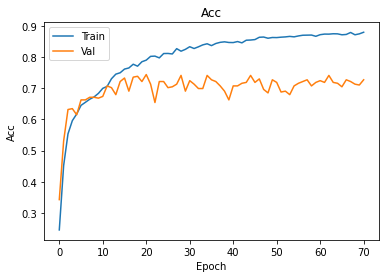

****************** Epoch: 72  ******************


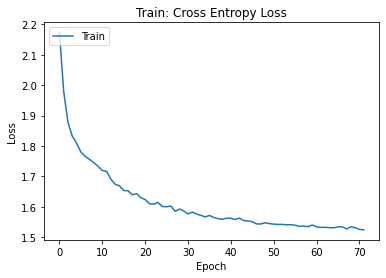

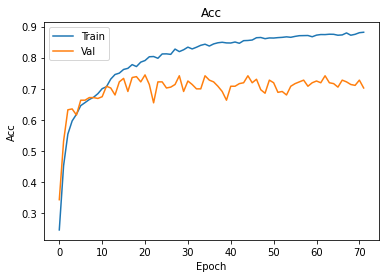

****************** Epoch: 73  ******************


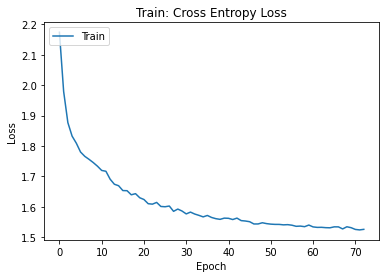

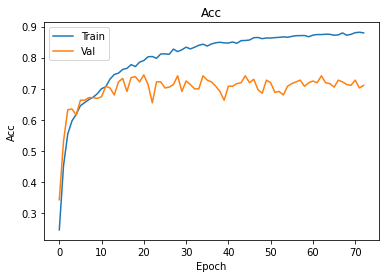

****************** Epoch: 74  ******************


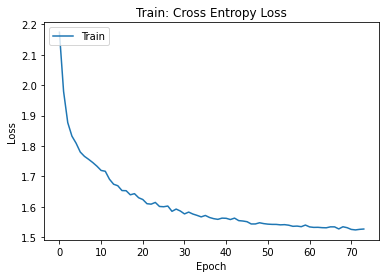

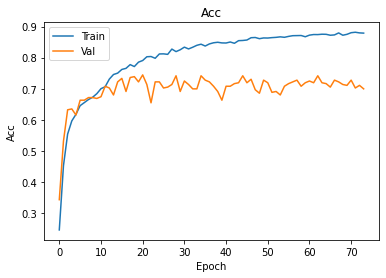

****************** Epoch: 75  ******************


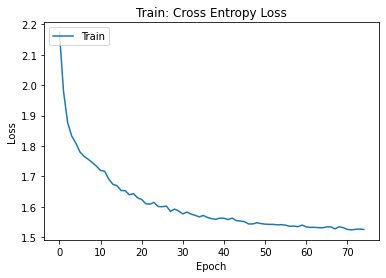

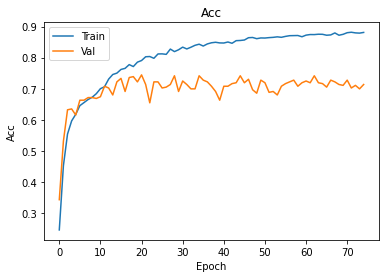

****************** Epoch: 76  ******************


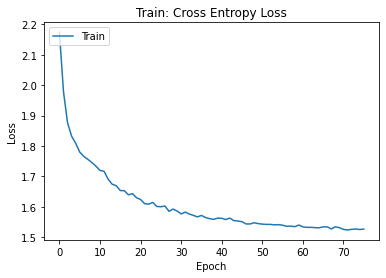

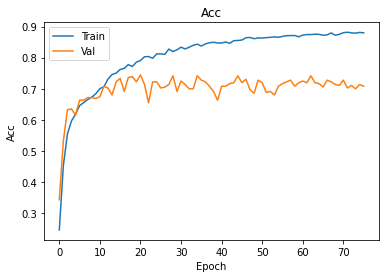

****************** Epoch: 77  ******************


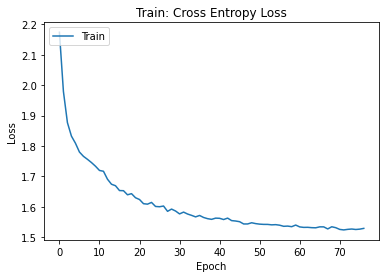

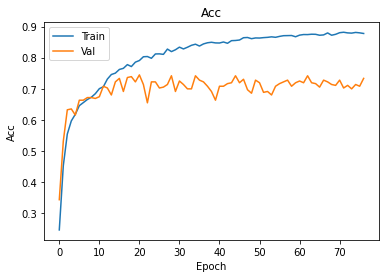

****************** Epoch: 78  ******************


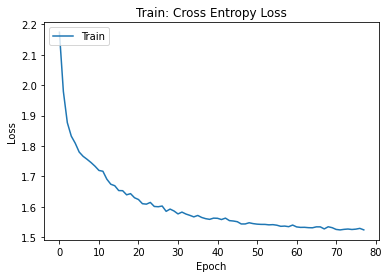

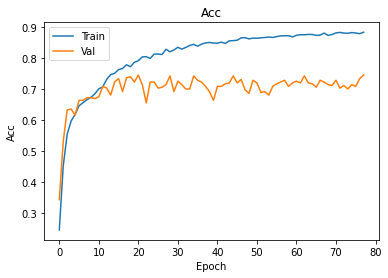

****************** Epoch: 79  ******************


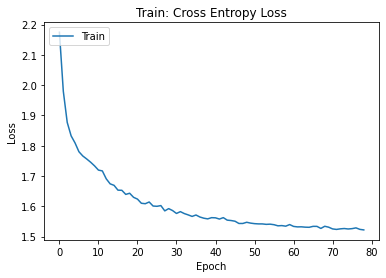

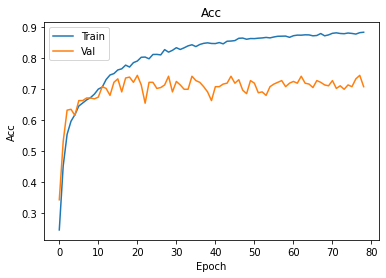

****************** Epoch: 80  ******************


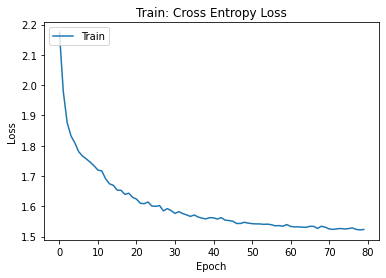

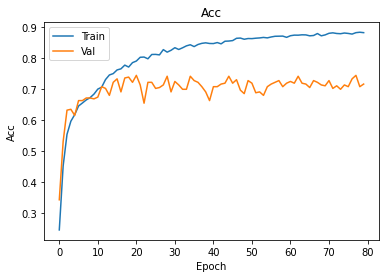

****************** Epoch: 81  ******************


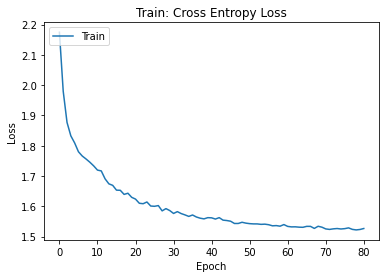

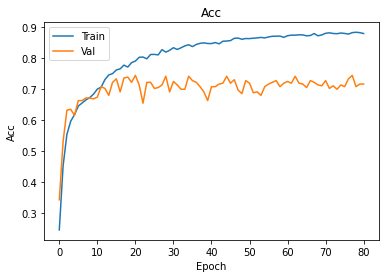

****************** Epoch: 82  ******************


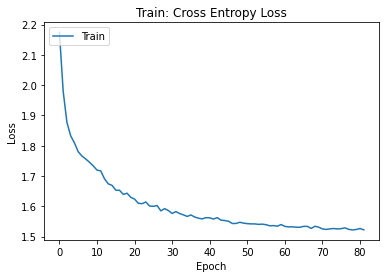

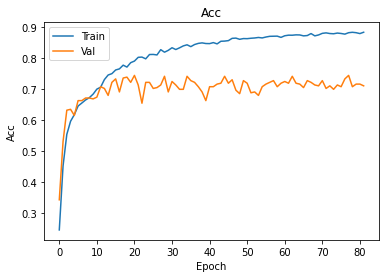

****************** Epoch: 83  ******************


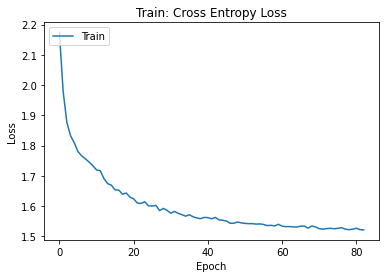

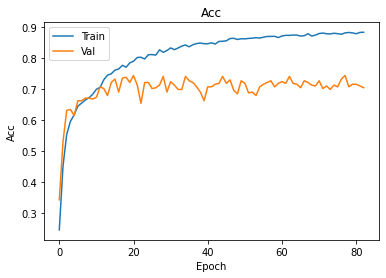

****************** Epoch: 84  ******************


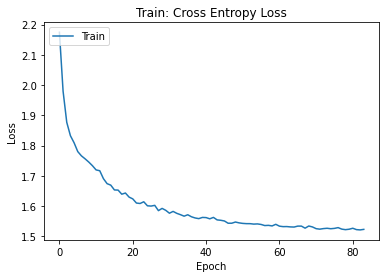

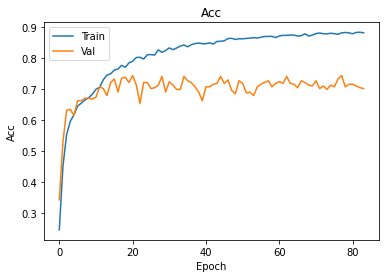

****************** Epoch: 85  ******************


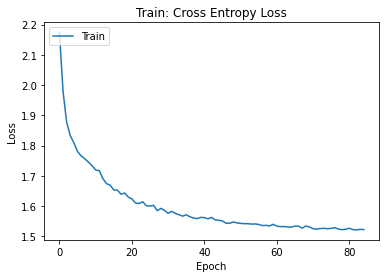

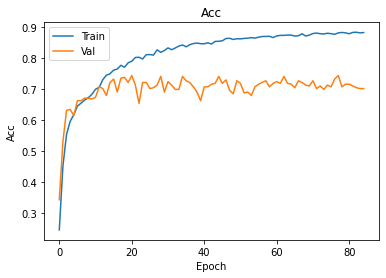

****************** Epoch: 86  ******************


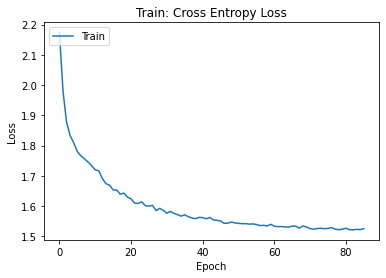

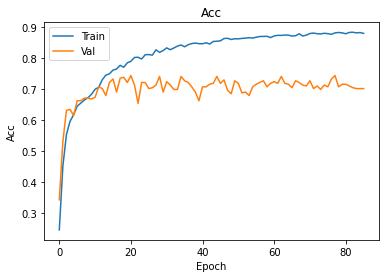

****************** Epoch: 87  ******************


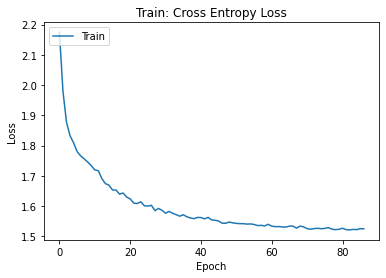

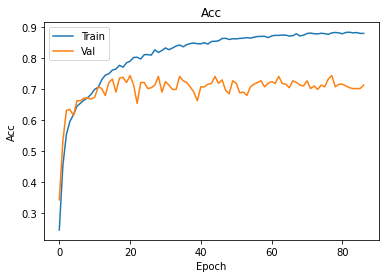

****************** Epoch: 88  ******************


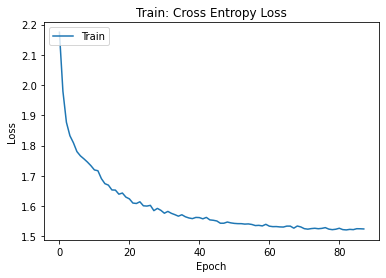

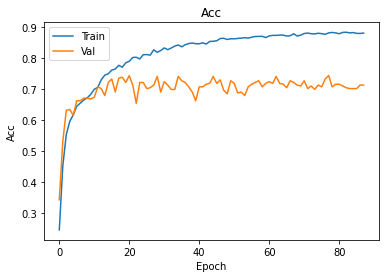

****************** Epoch: 89  ******************


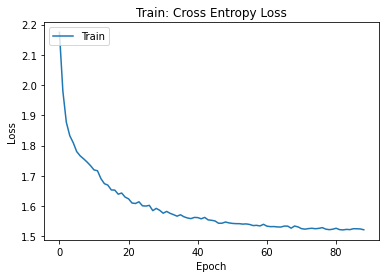

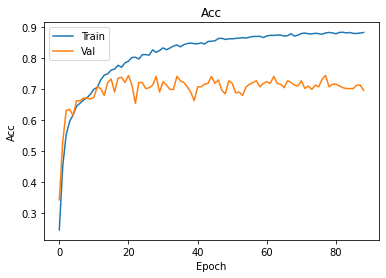

****************** Epoch: 90  ******************


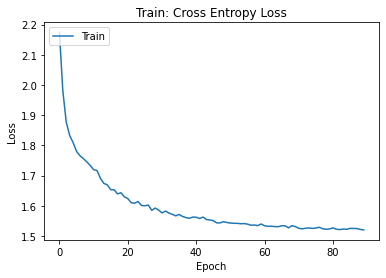

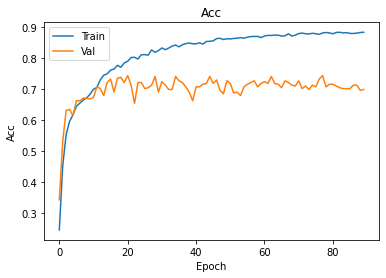

****************** Epoch: 91  ******************


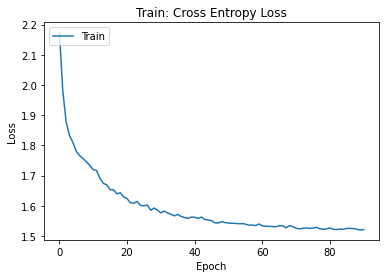

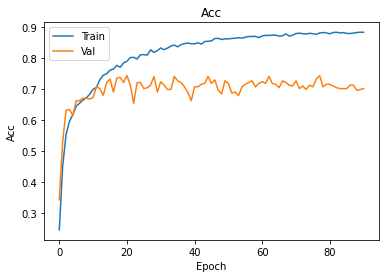

****************** Epoch: 92  ******************


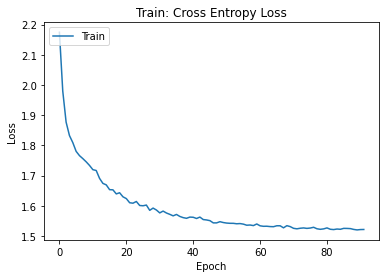

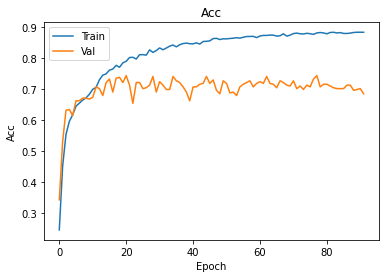

****************** Epoch: 93  ******************


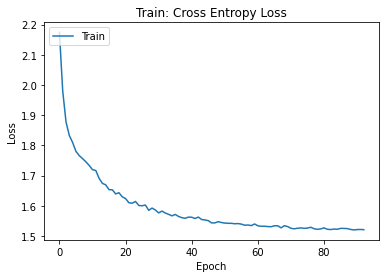

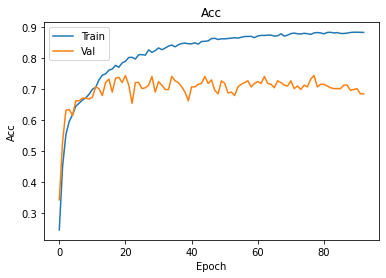

****************** Epoch: 94  ******************


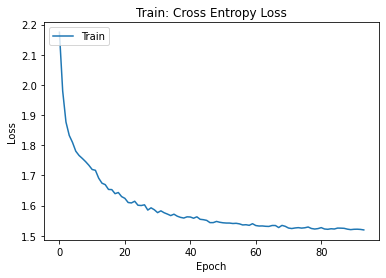

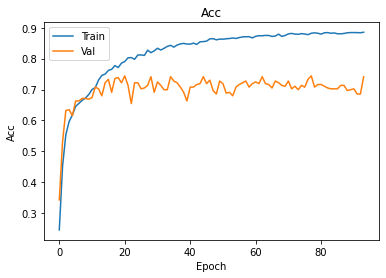

****************** Epoch: 95  ******************


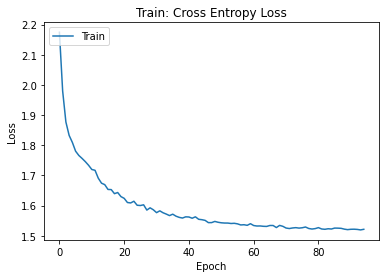

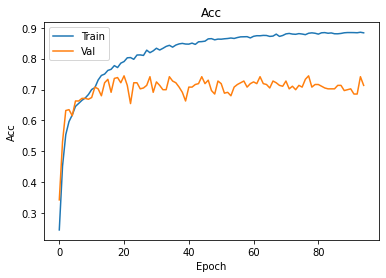

****************** Epoch: 96  ******************


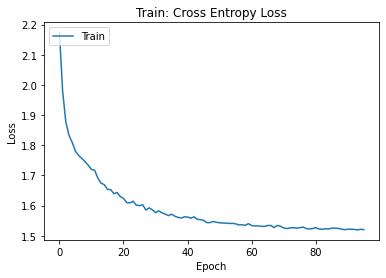

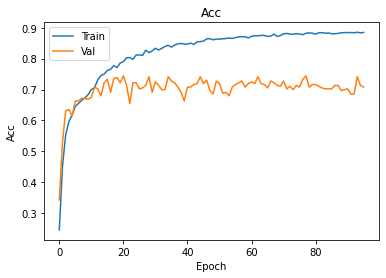

****************** Epoch: 97  ******************


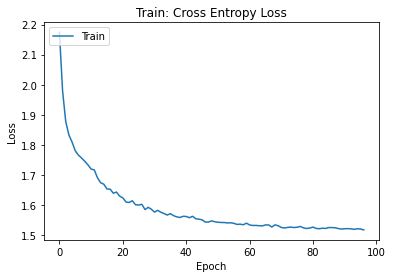

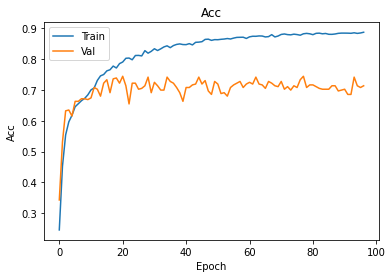

****************** Epoch: 98  ******************


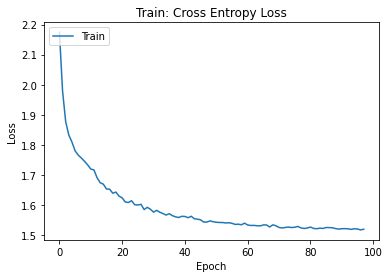

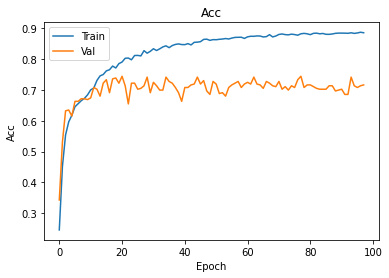

****************** Epoch: 99  ******************


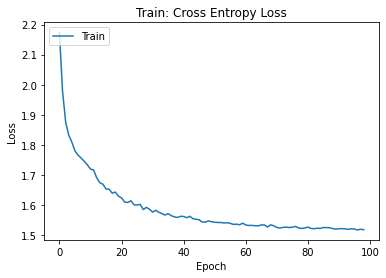

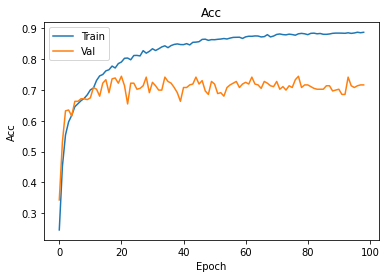

****************** Epoch: 100  ******************


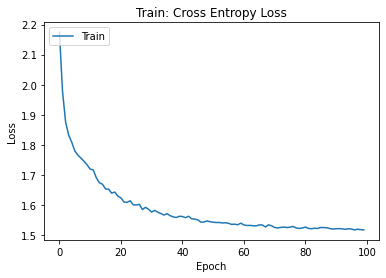

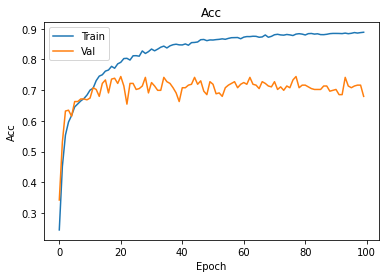

In [19]:
for epoch in range(numEpochs):
  net.train()
  stepTrain = 0; running_loss = 0; accTrain =0; lenDataTrain = 0
  print("****************** Epoch:", epoch+1," ******************")
  for caption, captionLabel, entities in trainRelationData:
    if torch.cuda.is_available:
      caption =  Variable(caption).cuda()
      captionLabel =  Variable(captionLabel).cuda()
      entities = Variable(entities).cuda()
    else:
        caption = Variable(caption)
        captionLabel =  Variable(captionLabel)
    entities = Variable(entities)
    outputs = net(caption[0:caption.shape[0]-1], entities)
    loss = criterion(outputs, captionLabel)
    running_loss += loss.item()
    stepTrain += 1
    optimizer.zero_grad()
    loss.backward(loss)
    optimizer.step()
    accTrain += (accuracy_score(captionLabel.cpu(), outputs.argmax(-1).cpu()))*len(captionLabel)
    lenDataTrain +=len(captionLabel)
  lossTrainHist.append(running_loss/stepTrain)
  accTrainHist.append(accTrain/lenDataTrain)
  epochHist.append(epoch)
  caption,captionLabel, entities = next(iter(valRelationData))
  outputs = net(caption[0:caption.shape[0]-1].cuda(), entities)
  accvalHist.append((accuracy_score(captionLabel.cpu(), outputs.argmax(-1).cpu())))
  myPlot(epoch = epochHist, trainLoss = lossTrainHist, yLebel = 'Loss', title = 'Train: Cross Entropy Loss')
  myPlot(epoch = epochHist, trainLoss = accTrainHist, yLebel = 'Acc', title = 'Acc', test = accvalHist)

**Test Val**

In [39]:
results = []
label = []
for caption,captionLabel, entities in testRelationData:
    myOutputs = net(caption[0:caption.shape[0]-1].cuda(), entities.cuda())
    results.append(myOutputs.detach().cpu().numpy())
    label.append(captionLabel.detach().cpu().numpy())
label = np.asarray(label)
results = np.concatenate((results[0], results[1]), axis = 0)
label = np.concatenate((label[0], label[1]), axis = 0)

(2,)

In [41]:
target_names = ['Cause-Effect', 'Instrument-Agency', 'Product-Producer','Content-Container',
                'Entity-Origin','Entity-Destination','Component-Whole','Member-Collection','Message-Topic','Other']
print(classification_report(label, results.argmax(-1), target_names=target_names))

                    precision    recall  f1-score   support

      Cause-Effect       0.87      0.90      0.88       328
 Instrument-Agency       0.00      0.00      0.00       156
  Product-Producer       0.56      0.57      0.57       231
 Content-Container       0.79      0.79      0.79       192
     Entity-Origin       0.80      0.70      0.75       258
Entity-Destination       0.91      0.82      0.86       292
   Component-Whole       0.70      0.71      0.70       312
 Member-Collection       0.78      0.61      0.69       233
     Message-Topic       0.77      0.67      0.72       261
             Other       0.35      0.57      0.44       454

          accuracy                           0.66      2717
         macro avg       0.65      0.63      0.64      2717
      weighted avg       0.66      0.66      0.66      2717



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
#classification_report(captionLabel.cpu(), outputs.argmax(-1).cpu(), target_names=[0,1,2,3,4,5,6,7,8,9])
print("The accuracy of the model is: %.1f%%" % (accuracy_score(label, results.argmax(-1))*100))

The accuracy of the model is: 66.1%


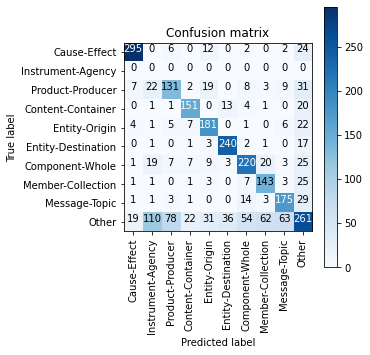

In [43]:
confusion_mtx = confusion_matrix(results.argmax(-1), label)
plot_confusion_matrix(confusion_mtx, target_names)